# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#2: The spectral exponent is correlated with population spike-synchrony

### Set-up

#### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd

from scipy.stats import linregress

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm, Normalize



In [2]:
# spike analysis toolboxes

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq


In [3]:
# voytek lab imports
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
# from fooof import FOOOF, FOOOFGroup


In [4]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import sim_ou_process, comp_exp, spiketimes_to_spiketrains, spikes_to_lfp


#### Settings

In [5]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"

In [6]:
# simulation settings
FS = 1000 # sampling frequency (1/dt)
N_SECONDS = 10 # duration of simulation (sec) 
N_NEURONS = 1000 # number of neurons in population

# analysis settings
F_RANGE = [1,100]


In [14]:
# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#3FAA96", "#F39943"]

# figure size
FIG_WIDTH = 18 # inches
FIG_HEIGHT = 9

#### Functions

In [8]:
# simualte LFP

def simulate_2_process_lfp(coupled, coupling_strength, n_seconds=1, fs=1000,
                          n_neurons=1000, mu_spike_rate=10, var_spike_rate=10):
    """
    simulate LFP

    Parameters
    ----------
    coupled : bool
        indicates whether the spiking activity is coupled to the global 
        population rate process.
    coupling_strength : float
        coupling strength value; indicates how tightly the spike rate of 
        each neuron is coupled to the global population rate process.
    n_seconds : float, optional
        duration of simulation (sec). The default is 1.
    fs : float, optional
        sampling frequency (Hz). The default is 1000.
    n_neurons : int, optional
        number of neurons in the population. The default is 1000.
    mu_spike_rate : flaot, optional
        mean firing rate of each neuron in the population. The default is 10.
    var_spike_rate : float, optional
        firing rate variance. The default is 10.

    Returns
    -------
    poisson_spikes : list
        list of spike trains.
    pop_rate : int, array
        population firing rate vector.
    lfp : flaot, array
        simulated local field potential.
    time : float, array
        time-vector for simulated lfp.

    """
    
    # imports
    from elephant.spike_train_generation import NonStationaryPoissonProcess

    # simualte random process (shared rate function across the population)
    ou, time = sim_ou_process(n_seconds, fs, 0.05, mu=0, sigma=var_spike_rate)

    # simulate spikes from random process
    poisson_spikes = []
    for i_neuron in range(n_neurons):
        rate_i = (mu_spike_rate + \
                 var_spike_rate*(np.random.rand(n_seconds*fs)-0.5)) + \
                 (ou * coupled * (coupling_strength*np.random.rand()))
        rate_i[rate_i<0] = 0
        rate = neo.AnalogSignal(rate_i, units=pq.Hz, sampling_rate=fs*pq.Hz)
        nspp = NonStationaryPoissonProcess(rate)
        poisson_spikes.append(nspp.generate_spiketrain(as_array=True))

    # convert spike times to spike trains
    _, spikes_array = spiketimes_to_spiketrains(poisson_spikes, fs, n_seconds, 
                                                return_matrix=True)
    pop_rate = np.sum(spikes_array, axis=0)

    # simulate LFP from spikes
    lfp = spikes_to_lfp(spikes_array, fs)
    
    return poisson_spikes, pop_rate, lfp, time

### Main

#### Simulate LFP
Two-process rate function (Kelly, 2010):
Each neurons rate is simulated as the sum of an independent rate (potentially stimulus-evoked or externally-influenced or computationally relevant) and a shared global rate. Each neuron has a particular coupling-strength which determines how much the global rate influnces its own rate.  
the rate process is modelled as  $\mu + W + OU * CS$   
where $\mu$ is the mean firing rate of the neuron, $W$ is white-nosie, $OU$ is the global rate fluctuations (modelled as an Ornstein–Uhlenbeck process), and $CS$ is the coupling-strength 

In [9]:
# simulate LFP
coupled = [0, 1, 1]
coupling_strength = [0, 0.5, 1]

pop_spikes = []
lfps = []
pop_rates = []
for cp, cs in zip(coupled, coupling_strength):
    poisson_spikes, pop_rate, lfp, time = simulate_2_process_lfp(cp, cs, 
        n_seconds=N_SECONDS, fs=FS, n_neurons=N_NEURONS)
    pop_spikes.append(poisson_spikes)
    pop_rates.append(pop_rate)
    lfps.append(lfp)

lfps = np.vstack(lfps)
pop_rates = np.vstack(pop_rates)
print(pop_rates.shape)
print(lfp.shape)


(3, 10001)
(9952,)


In [10]:
# compute psd and exponent

# init
_, temp = compute_spectrum(lfps[0], FS, f_range=F_RANGE)
spectra = np.zeros([len(lfps), len(temp)])

# compute psd
for i_lfp, signal in enumerate(lfps):
    freq, spectra[i_lfp] = compute_spectrum(signal, FS, f_range=F_RANGE)
    
# comp exp
# exp = comp_exp_group(lfps, FS)
exp = comp_exp(lfps, FS)
print(exp)


Running FOOOFGroup across 3 power spectra.
[1.92121245 2.19084302 2.4985116 ]


C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:53: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


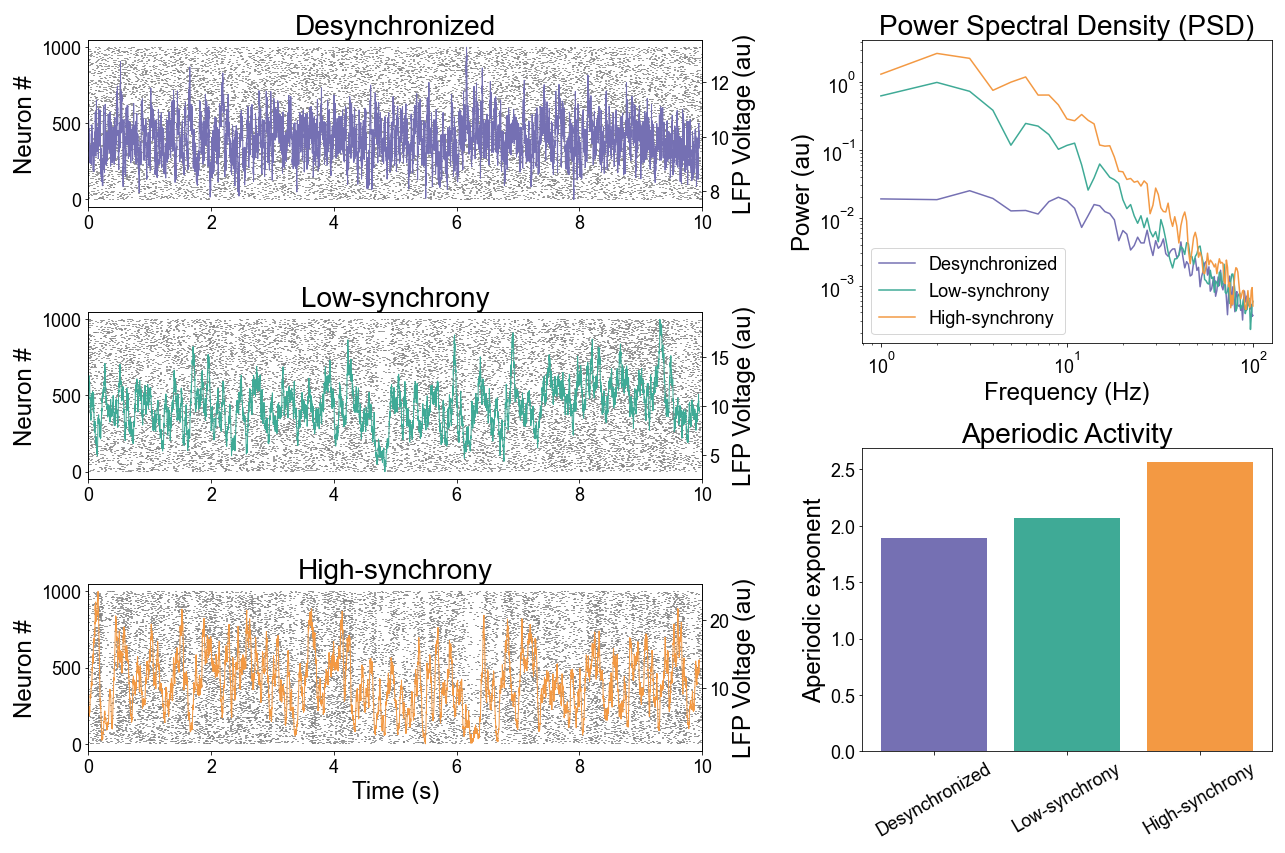

In [11]:
# plot simulation results

# labels
labels = ['Desynchronized', 'Low-synchrony', 'High-synchrony']

# create figure and axes
fig = plt.figure(figsize=[FIG_WIDTH,12])

# set up gridspec
# spec = gridspec.GridSpec(ncols=5, nrows=6, figure=fig, hspace=0.3, wspace=0.3)
spec = gridspec.GridSpec(ncols=2, nrows=6, figure=fig, width_ratios=[3,2])
ax0 = fig.add_subplot(spec[:2,0])
ax1 = fig.add_subplot(spec[2:4,0])
ax2 = fig.add_subplot(spec[4:6,0])
ax3 = fig.add_subplot(spec[:3,1])
ax4 = fig.add_subplot(spec[3:,1])

# plot spikes and lfp
for ii, ax in enumerate([ax0,ax1,ax2]):
    # plot spikes
    ax.eventplot(pop_spikes[ii], color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,N_SECONDS])
    # plot LFP
    axr = ax.twinx() 
    axr.plot(time[:len(lfps[0])],lfps[ii], linewidth=1, color=COLORS[ii])
    axr.set(ylabel='LFP Voltage (au)')
ax2.set(xlabel='Time (s)', ylabel='Neuron #')

# plot PSD
for ii in range(len(spectra)):
    ax3.loglog(freq, spectra[ii], color=COLORS[ii])
    ax3.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax3.legend(labels, loc='lower left')

# plot exp barchart
ax4.bar([0,1,2], exp, color=COLORS)
ax4.set(ylabel='Aperiodic exponent')
ax4.set_xticks([0,1,2])
ax4.set_xticklabels(labels, rotation=30)

# set titles
ax0.set_title('Desynchronized')
ax1.set_title('Low-synchrony')
ax2.set_title('High-synchrony')
ax3.set_title('Power Spectral Density (PSD)')
ax4.set_title('Aperiodic Activity')

# adjust spcing
spec.tight_layout(figure=fig, h_pad=1, w_pad=2)

# save
plt.savefig(DIR_FIG + '/panel_2_fig1.png')

#### Repeat simulation across many synchrony levels and regress spike synchrony metrics with LFP exponent

In [11]:
#  repeat with many levels

coupling_strength = np.linspace(0,1,11)
coupling_min = np.zeros(len(coupling_strength)) + 0.2
coupled = np.ones(len(coupling_strength))

# simulate LFP
pop_spikes_x = []
lfps_x = []
pop_rates_x = []
for cp, cs, cm in zip(coupled, coupling_strength, coupling_min):
    print(cs)
    poisson_spikes, pop_rate, lfp, time = simulate_2_process_lfp(cp, cs,
        n_seconds=N_SECONDS, fs=FS, n_neurons=N_NEURONS)
    pop_spikes_x.append(poisson_spikes)
    pop_rates_x.append(pop_rate)
    lfps_x.append(lfp)
    
# compute exp
exp = comp_exp(np.vstack(lfps_x), FS)
print(exp)


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
Running FOOOFGroup across 11 power spectra.
[2.03132404 1.73492621 1.84006614 2.11634747 1.97138217 1.98175205
 2.22958091 2.31319277 2.42062855 2.5485913  2.55790798]


In [12]:
# compute correlation/covarience measures

corr_mat = np.zeros([len(coupling_strength),N_NEURONS,N_NEURONS])
cov_mat = np.zeros([len(coupling_strength),N_NEURONS,N_NEURONS])
corr_mu = np.zeros(len(coupling_strength))
cov_mu = np.zeros(len(coupling_strength))

for ii in range(len(coupling_strength)):
    spike_times = pop_spikes_x[ii]

    n_units = len(spike_times)
    spike_trains = []
    for i_unit in range(n_units):
        sp = neo.SpikeTrain(spike_times[i_unit]*pq.s, N_SECONDS*pq.s)
        spike_trains.append(sp)

    # compute corr
    cov_mat[ii] = covariance(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    cov_mu[ii] = np.mean(cov_mat[ii])
    corr_mat[ii] = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    corr_mu[ii] = np.mean(corr_mat[ii])


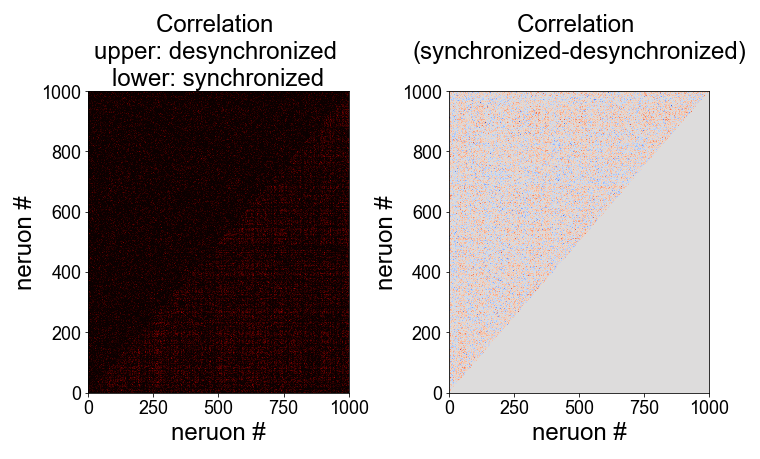

In [14]:
# plot correlation matrix

# combine data for compact plotting
temp0 = np.tril(corr_mat[0], -1)
temp1 = np.triu(corr_mat[-1], 1)
corr_mat_comb = temp0+temp1

# compute norm for colorbar
temp = corr_mat[-1]-corr_mat[0]
norm_2s = TwoSlopeNorm(vmin=temp.min(), vcenter=0, vmax=temp.max())
norm = Normalize(vmin=0, vmax=np.max(corr_mat)*0.8)

# plot colormesh
fig, axes = plt.subplots(1,2,figsize=[10,6])
axes[0].pcolormesh(corr_mat_comb, cmap='hot', norm=norm)
axes[1].pcolormesh(np.tril(corr_mat[-1]-corr_mat[0], -1), cmap='coolwarm', norm=norm_2s)

# label figure
axes[0].set_title('Correlation \nupper: desynchronized \nlower: synchronized', fontsize=24)
axes[1].set_title('Correlation \n(synchronized-desynchronized)\n', fontsize=24)
for ax in axes:
    ax.set(xlabel='neruon #', ylabel='neruon #')

# save
plt.savefig(DIR_FIG + '/panel_2_fig2.png')
    


LinregressResult(slope=38.211842703802404, intercept=1.8503005926371823, rvalue=0.9165601534163587, pvalue=7.259136996168233e-05, stderr=5.557298562319179, intercept_stderr=0.057119204882664844)
LinregressResult(slope=336.40066828827895, intercept=1.8674410666317744, rvalue=0.9153816261747816, pvalue=7.718604079005162e-05, stderr=49.31663095015634, intercept_stderr=0.05559678152841953)


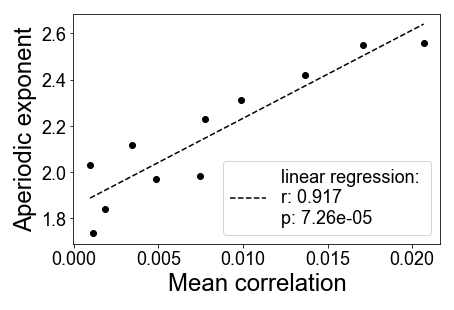

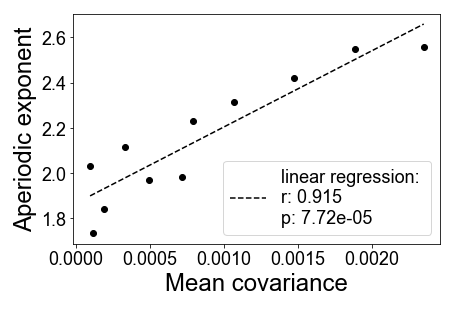

In [13]:
# plot each sync measure
for var, var_str in zip([corr_mu, cov_mu], ['Mean correlation','Mean covariance']):
    # regression
    lin_reg = linregress(var, exp)
    print(lin_reg)

    # plot regression results
    fig, ax = plt.subplots()
    ax.scatter(var, exp, color='k')

    # label
    ax.set(xlabel=var_str, ylabel='Aperiodic exponent')
    ax.plot([var.min(),var.max()],[var.min()*lin_reg[0]+lin_reg[1],var.max()*lin_reg[0]+lin_reg[1]],
           color='k', linestyle='--', 
            label=f'linear regression: \nr: {np.round(lin_reg[2],3)} \np: {lin_reg[3]:.2e}')

    ax.legend()

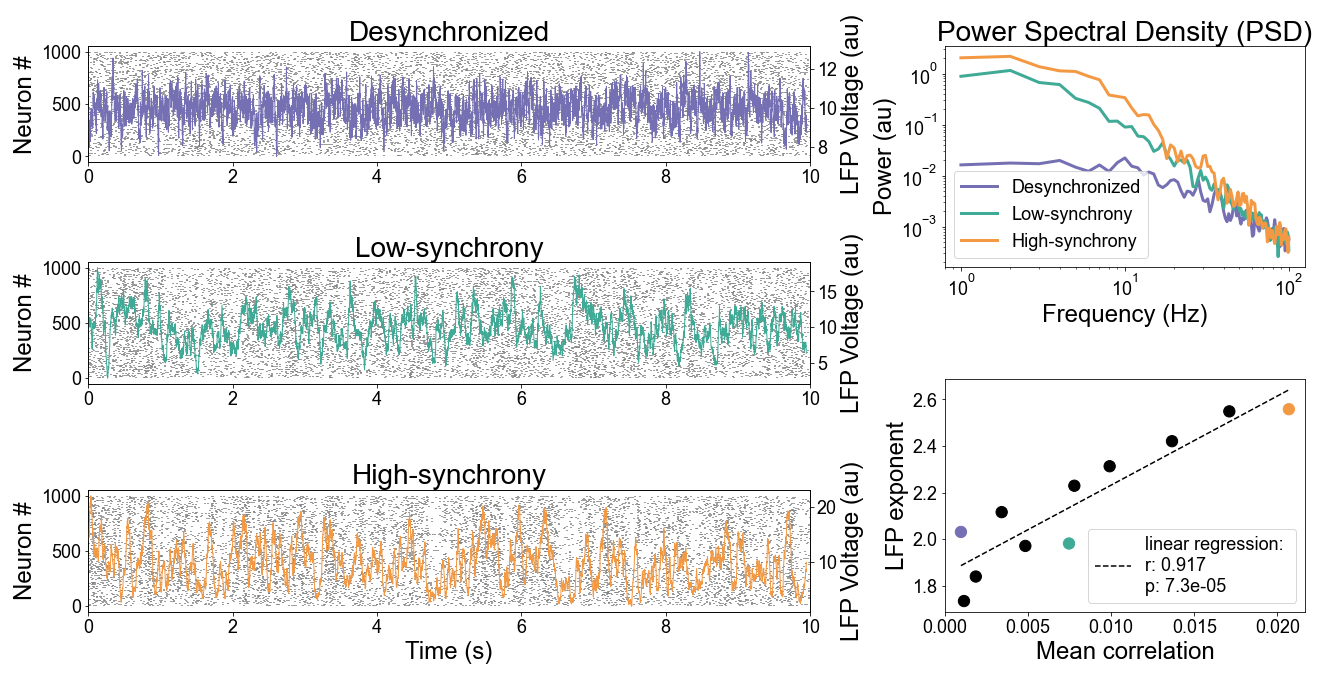

In [15]:
# create figure

# chosse var
sync = corr_mu
sync_label = 'Mean correlation'

# labels
labels = ['Desynchronized', 'Low-synchrony', 'High-synchrony']

# create figure and axes
fig = plt.figure(figsize=[FIG_WIDTH,FIG_HEIGHT])

# set up gridspec
spec = gridspec.GridSpec(ncols=2, nrows=6, figure=fig, width_ratios=[2,1])
ax0 = fig.add_subplot(spec[:2,0])
ax1 = fig.add_subplot(spec[2:4,0])
ax2 = fig.add_subplot(spec[4:6,0])
ax3 = fig.add_subplot(spec[:3,1])
ax4 = fig.add_subplot(spec[3:,1])

# plot spikes and lfp
for ii, ax in enumerate([ax0,ax1,ax2]):
    # plot spikes
    ax.eventplot(pop_spikes[ii], color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,N_SECONDS])
    # plot LFP
    axr = ax.twinx() 
    axr.plot(time[:len(lfps[0])],lfps[ii], linewidth=1, color=COLORS[ii])
    axr.set(ylabel='LFP Voltage (au)')
ax2.set(xlabel='Time (s)', ylabel='Neuron #')

# plot PSD
for ii in range(len(spectra)):
    ax3.loglog(freq, spectra[ii], linewidth=3, color=COLORS[ii])
    ax3.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax3.legend(labels, loc='lower left')

# plot regression results
lin_reg = linregress(sync, exp)
ax4.scatter(sync, exp, color=[COLORS[0],'k','k','k','k',COLORS[1],'k','k','k','k',COLORS[2]], s=128)
ax4.set(xlabel=sync_label, ylabel='LFP exponent')
ax4.plot([sync.min(),sync.max()],[sync.min()*lin_reg[0]+lin_reg[1],sync.max()*lin_reg[0]+lin_reg[1]],
       color='k', linestyle='--', 
        label=f'linear regression: \nr: {np.round(lin_reg[2],3)} \np: {lin_reg[3]:0.1e}')
ax4.legend()

# set titles
ax0.set_title('Desynchronized')
ax1.set_title('Low-synchrony')
ax2.set_title('High-synchrony')
ax3.set_title('Power Spectral Density (PSD)')

# save
plt.savefig(DIR_FIG + '/panel_2_fig3.png')
